In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, algebra, quadrature
#from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import itertools
import time
import statistics as st
from pyiga import algebra_cy, ieti_cy
import math

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
kvy = [8,4,8,5,2,4]
kvx = [2,4,3,6,5,8]
deg=2

b = geometry.line_segment(np.array([0,1]),np.array([2,1])).as_nurbs()
t = geometry.line_segment(np.array([1,2]),np.array([2,2])).as_nurbs()
l = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[0.,1.],[0.2,1.8],[1.,2.]]),weights = np.array([1.,1/sqrt(2),1.]))
r = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2,1.5],[2,2]]), weights = np.array([1.,1.,1.]))
kvs_g2, coeffs_g2 = geometry._combine_boundary_curves(b,t,l,r)
geo2 = geometry.NurbsFunc(kvs_g2, coeffs_g2[:,:,:2], coeffs_g2[:,:,2].reshape(3,2), premultiplied=1)

l = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2,  1.5],[2,  2  ]]), weights = np.array([1.,1.,       1.]))
r = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[3,1],[3.5,1.5],[3.5,2.5]]), weights = np.array([1.,1/sqrt(2),1.]))
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2.5,1  ],[3,  1  ]]), weights = np.array([1.,1.,       1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,2],[2.5,2.5],[3.5,2.5]]), weights = np.array([1.,1/sqrt(2),1.]))
kvs_g3, coeffs_g3 = geometry._combine_boundary_curves(b,t,l,r)
coeffs_g3[1,1] = np.array([2.75,1.75,1.0])
geo3 = geometry.NurbsFunc(kvs_g3, coeffs_g3[:,:,:2], coeffs_g3[:,:,2], premultiplied=1)

l = geometry.line_segment(np.array([2,1]),np.array([3,1])).as_nurbs()
r = geometry.line_segment(np.array([2.5,-.5]),np.array([3,0])).as_nurbs()
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[2.,1],[2.5,0.5],[3,0]]),weights = np.array([1.,1.,1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[3,1],[3,0.5],[3.5,0.5]]), weights = np.array([1.,1/sqrt(2),1.]))
kvs_g4, coeffs_g4 = geometry._combine_boundary_curves(b,t,l,r)
geo4 = geometry.NurbsFunc(kvs_g4, coeffs_g4[:,:,:2], coeffs_g4[:,:,2].reshape(2,3), premultiplied=1)

l = geometry.line_segment(np.array([2,0]),np.array([2,1])).as_nurbs()
r = geometry.line_segment(np.array([3,0]),np.array([3.5,0.5])).as_nurbs()
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[2.,0.],[2.5,0],[2.5,-.5]]),weights = np.array([1.,1/sqrt(2),1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2.5,0.5],[3,0]]), weights = np.array([1.,1.,1.]))
kvs_g5, coeffs_g5 = geometry._combine_boundary_curves(b,t,l,r)
geo5 = geometry.NurbsFunc(kvs_g5, coeffs_g5[:,:,:2], coeffs_g5[:,:,2].reshape(2,3), premultiplied=1)


kvs=[(bspline.make_knots(deg,0.0,1.0,xN),bspline.make_knots(deg,0.0,1.0,yN)) for xN,yN in zip(kvx,kvy)]
geos=[geometry.unit_square(support=((0.,1.),(0.0,0.5))).scale((2,1)),
      geometry.unit_square(support=((0.,1.),(0.5,1.))).scale((2,1)),
      # geometry.Quad(np.array([[0.,2.,1.,2.],
      #                         [1.,1.,2.,2.]])),
      geo2,
      geo3,
      # geometry.Quad(np.array([[2.,3.,2.,3.5],
      #                         [1.,1.,2.,2.5]])),
      geo4,
      # geometry.Quad(np.array([[2.,3.,3.,3.5],
      #                         [1.,0.,1.,0.5]])),
      geo5
     ]
      # geometry.Quad(np.array([[2.,2.5,2.,3.],
      #                         [0.,-0.5,1.,0.]])),]

patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]

conn, interfaces = assemble.detect_interfaces(patches)
for i in range(len(interfaces)):
    (p1, bdspec1, p2, bdspec2, conn_info) = interfaces[i]
    interfaces[i] = ((p1, topology.bdspec_to_int(bdspec1), 0), (p2, topology.bdspec_to_int(bdspec2), 0), conn_info[1][0])

interfaces = interfaces + [
    ((2,0,0),(0,1,0),False),
    ((2,0,1),(1,1,0),False)
]

M = topology.PatchMesh(patches, interfaces)
MP = assemble.Multipatch(M, automatch=True)
#M.sanity_check()
#M.h_refine(patches={5:-1, 2:-1});

setting up constraints took 0.006070613861083984 seconds.
Basis setup took 0.0030329227447509766 seconds


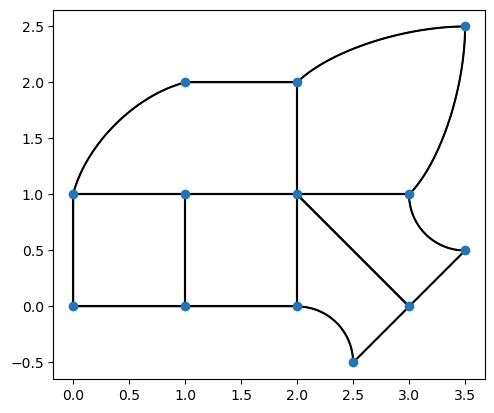

In [3]:
MP.mesh.draw(knots=0, nodes=1, patch_idx=0)

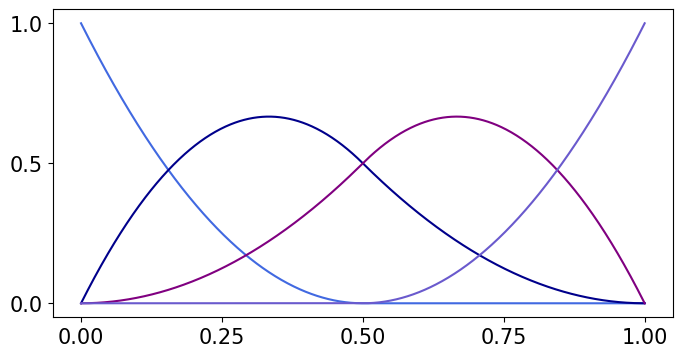

In [6]:
kv1 = bspline.make_knots(2,0.0,1.0,2)
x = np.linspace(0,1,1000)
func1 = [bspline.BSplineFunc(kv1,np.eye(1,kv1.numdofs,i).ravel()) for i in range(kv1.numdofs)]
col1=['royalblue','darkblue','purple','slateblue']
fig = plt.figure(figsize=(8,4))
for i in range(kv1.numdofs):
    plt.plot(x,func1[i](x),color=col1[i])
    plt.xticks(np.array([0,0.25,0.5,0.75,1]),fontsize=15)
    plt.yticks(np.array([0,0.5,1]),fontsize=15)
plt.show()

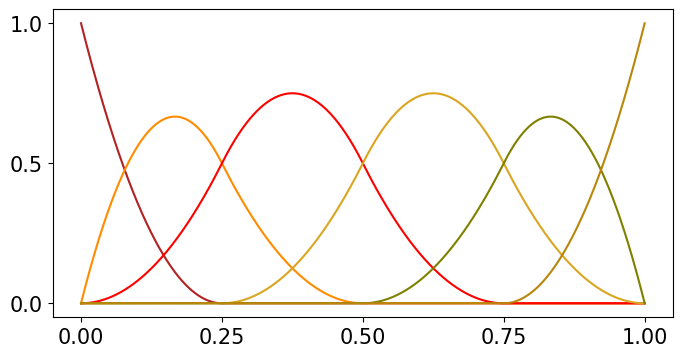

In [7]:
kv2 = bspline.make_knots(2,0.0,1.0,4)
func2 = [bspline.BSplineFunc(kv2,np.eye(1,kv2.numdofs,i).ravel()) for i in range(kv2.numdofs)]
fig = plt.figure(figsize=(8,4))
col2=['firebrick','darkorange','red','goldenrod','olive','darkgoldenrod']
for i in range(kv2.numdofs):
    plt.plot(x,func2[i](x),color=col2[i])
    plt.xticks(np.array([0,0.25,0.5,0.75,1]), fontsize=15)
    plt.yticks(np.array([0,0.5,1]),fontsize=15)
plt.show()

In [8]:
P = bspline.prolongation(kv1,kv2).tocsc()

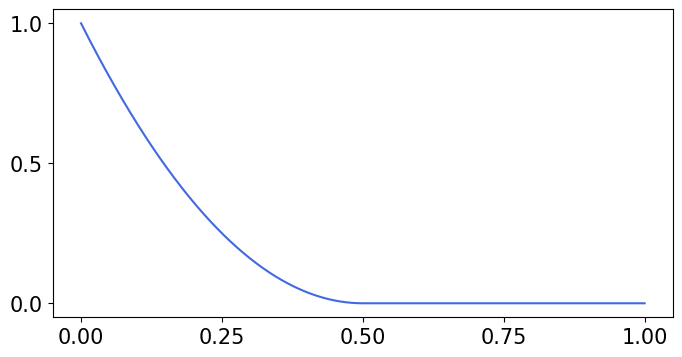

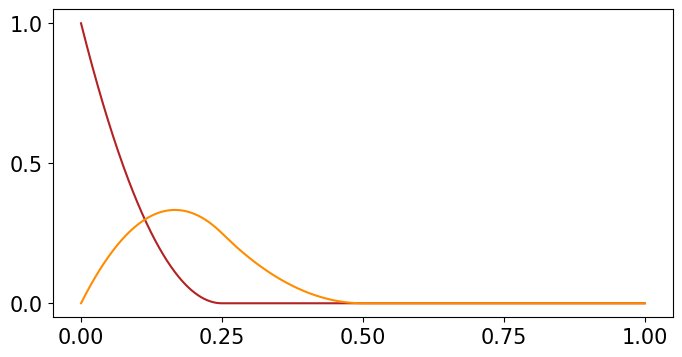

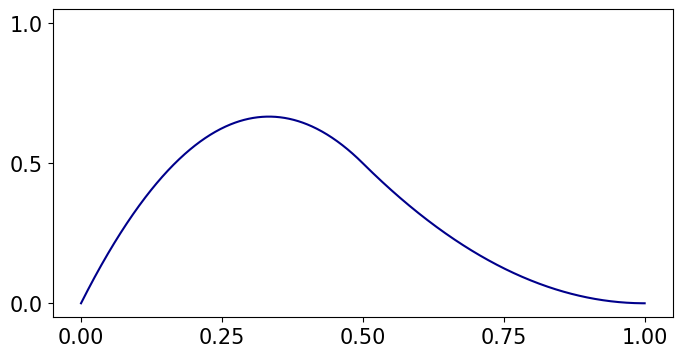

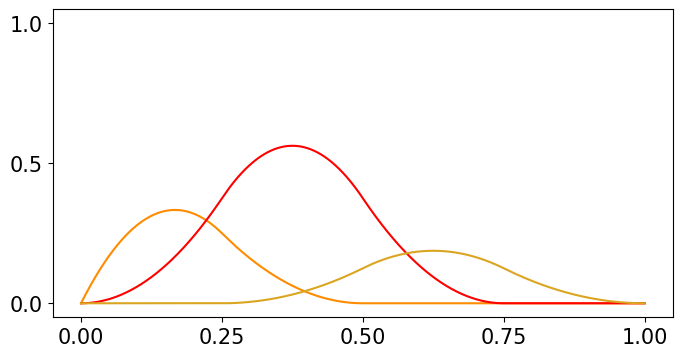

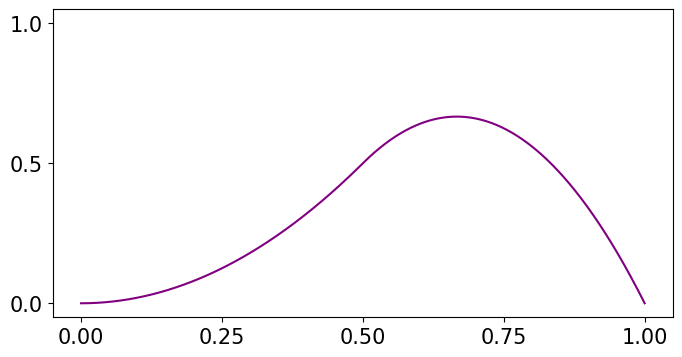

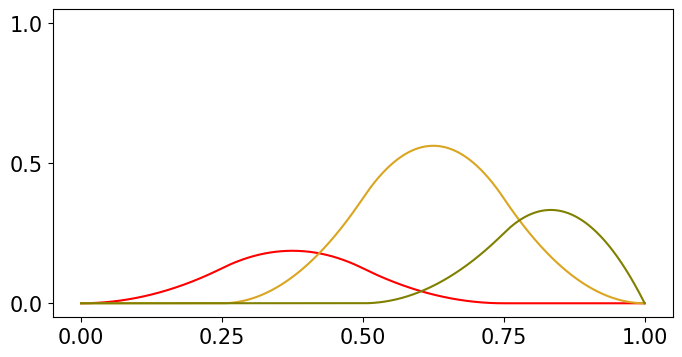

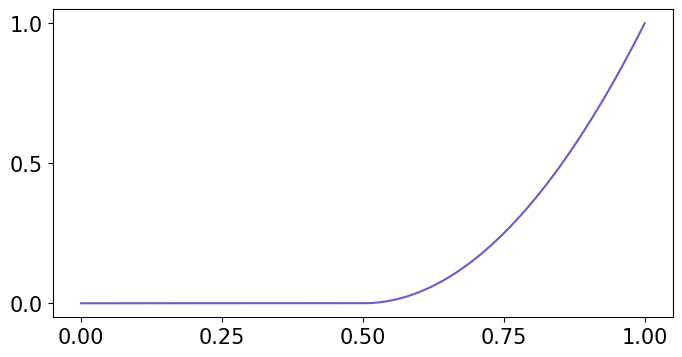

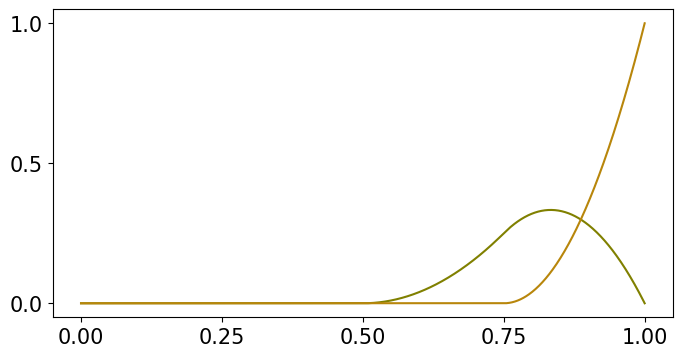

In [9]:
for j in range(P.shape[1]):
    fig = plt.figure(figsize=(8,4))
    plt.plot(x,func1[j](x),color=col1[j])
    plt.xticks(np.array([0,0.25,0.5,0.75,1]), fontsize=15)
    plt.yticks(np.array([0,0.5,1]),fontsize=15)
    plt.ylim(-0.05,1.05)
    plt.show()
    fig = plt.figure(figsize=(8,4))
    for i in P[:,j].indices:
        plt.plot(x,P[i,j]*func2[i](x),color=col2[i])
        plt.xticks(np.array([0,0.25,0.5,0.75,1]), fontsize=15)
        plt.yticks(np.array([0,0.5,1]),fontsize=15)
        plt.ylim(-0.05,1.05)
    plt.show()

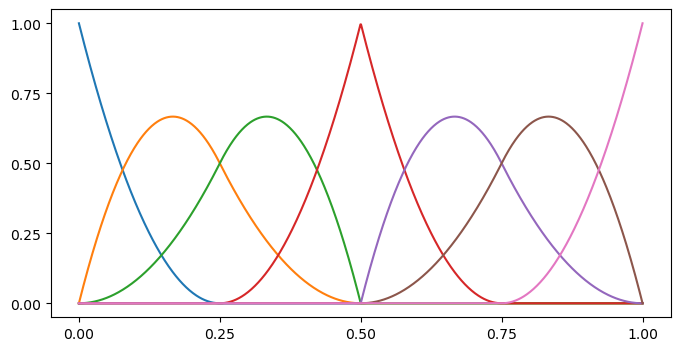

In [10]:
kv3 = bspline.KnotVector(np.array([0,0,0,0.25,0.5,0.5,0.75,1,1,1]),2)
func3 = [bspline.BSplineFunc(kv3,np.eye(1,kv3.numdofs,i).ravel()) for i in range(kv3.numdofs)]
fig = plt.figure(figsize=(8,4))
for i in range(kv3.numdofs):
    plt.plot(x,func3[i](x))
    plt.xticks(np.array([0,0.25,0.5,0.75,1]))
    plt.yticks(np.array([0,0.25,0.5,0.75,1]))
plt.show()

In [11]:
P = bspline.prolongation(kv1,kv3).A

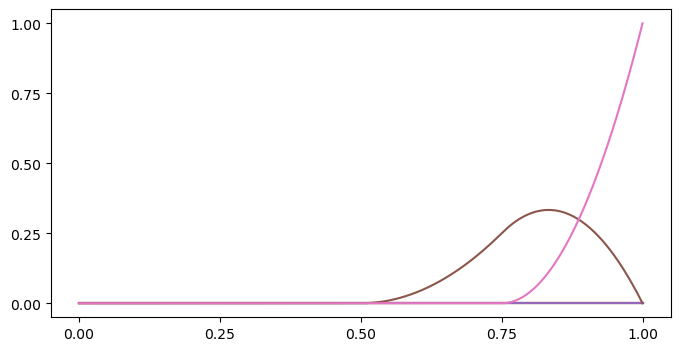

In [12]:
j=3
fig = plt.figure(figsize=(8,4))
for i in range(P.shape[0]):
    plt.plot(x,P[i,j]*func3[i](x))
    plt.xticks(np.array([0,0.25,0.5,0.75,1]))
    plt.yticks(np.array([0,0.25,0.5,0.75,1]))
plt.show()

In [13]:
for i in range(7):
    MP.h_refine(-1)

Refinement took 0.0007894039154052734 seconds for 6 patches.
setting up constraints took 0.006751060485839844 seconds.
Basis setup took 0.003151416778564453 seconds
Refinement took 0.0001266002655029297 seconds for 6 patches.
setting up constraints took 0.01714634895324707 seconds.
Basis setup took 0.0036971569061279297 seconds
Refinement took 0.00015425682067871094 seconds for 6 patches.
setting up constraints took 0.009415864944458008 seconds.
Basis setup took 0.004565000534057617 seconds
Refinement took 0.00014066696166992188 seconds for 6 patches.
setting up constraints took 0.013583660125732422 seconds.
Basis setup took 0.010605573654174805 seconds
Refinement took 0.0001678466796875 seconds for 6 patches.
setting up constraints took 0.02503061294555664 seconds.
Basis setup took 0.042792320251464844 seconds
Refinement took 0.00020265579223632812 seconds for 6 patches.
setting up constraints took 0.0556180477142334 seconds.
Basis setup took 0.18315744400024414 seconds
Refinement too

In [14]:
Constr = MP.Constr

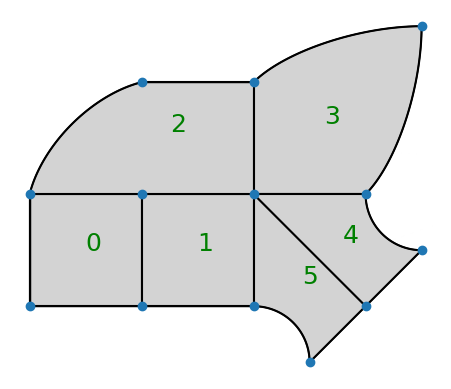

In [15]:
MP.mesh.draw(knots=1, patch_idx=1, nodes=1, axis='off')
axis('scaled');

In [17]:
MP.get_nodes()

{0: [array([0], dtype=int32)],
 1025: [array([  1025, 264708], dtype=int32)],
 264194: [array([ 265221, 1584916], dtype=int32)],
 526851: [array([263682, 528904], dtype=int32)],
 527876: [array([ 528903,  529929,  924940, 1419280, 2111766], dtype=int32)],
 921861: [array([923914], dtype=int32)],
 922886: [array([ 924939, 1418638], dtype=int32)],
 923527: [array([ 925581, 1584658], dtype=int32)],
 1416456: [array([1419279], dtype=int32)],
 1416713: [array([1419537, 2112279], dtype=int32)],
 1581450: [array([1584915], dtype=int32)],
 1581963: [array([1585429], dtype=int32)],
 (527364, 527363): [array([264707, 528390]),
  array([529416, 529417], dtype=int32)]}

In [18]:
loc_corners = np.concatenate([assemble.boundary_dofs(kvs,m=0,ravel=1)+MP.N_ofs[p] for p,kvs in enumerate(kvs)])
dir_dofs = np.unique(np.concatenate([assemble.boundary_dofs(kvs[p],bdspec=[assemble.int_to_bdspec(b)],ravel=1)+MP.N_ofs[p] for p,b in MP.mesh.outer_boundaries[0]]))
node_dofs = np.setdiff1d(loc_corners,dir_dofs)

In [19]:
node_dofs

array([     39,  264738,  264743,  528913,  924940, 1419280, 1584970])

In [20]:
print(MP.Basis[node_dofs,:])

  (0, 39)	1.0
  (1, 263711)	1.0
  (2, 263716)	1.0
  (3, 526860)	1.0
  (4, 527876)	1.0
  (5, 527876)	1.0
  (6, 1581504)	1.0


In [46]:
def drawSkeleton(MP):
    for (p1,b1,_),(p2,b2,_),_ in MP.intfs:
        ax1,sd1=assemble.int_to_bdspec(b1)
        geo=MP.mesh.geos[p1]
        kvs=MP.mesh.kvs[p1]
        grid1=np.linspace(geo.support[(ax1+1)%2][0], geo.support[(ax1+1)%2][1],kvs[(ax1+1)%2].numdofs)
        if (p1,b1) == (4,1) or (p1,b1)==(5,3): grid=grid[1:-1]
        if ax1==0:
            Z = geo.eval(grid1,np.array([geo.support[0][sd1]]))
        else:
            Z = geo.eval(np.array([geo.support[1][sd1]]),grid1)
        plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='red',s=15,zorder=3)
    plt.axis('off');
    
def drawInterior(MP,r=1):
    for p in range(MP.numpatches):
        kvs, geo = MP.mesh.kvs[p], MP.mesh.geos[p]
        gridx=np.linspace(geo.support[0][0],geo.support[0][1] ,kvs[0].numdofs)
        gridy=np.linspace(geo.support[1][0],geo.support[1][1],kvs[1].numdofs)
        Z = geo.eval(gridx,gridy)
        if r != 0:
            plt.scatter(Z[r:-r,r:-r,0].ravel(),Z[r:-r,r:-r,1].ravel(),color='black',s=15)
        else:
            for idx in MP.mesh.outer_boundaries:
                if (p,2) not in MP.mesh.outer_boundaries[idx]: Z = Z[1:,:,:]
                if (p,3) not in MP.mesh.outer_boundaries[idx]: Z = Z[:-1,:,:]
                if (p,0) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,1:,:]
                if (p,1) not in MP.mesh.outer_boundaries[idx]: Z = Z[:,:-1,:]
            plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='black',s=15,zorder=2)
    plt.axis('off');
    
def drawLocal(MP,ofs):
    for p in range(MP.numpatches):
        kvs, geo = MP.mesh.kvs[p], MP.mesh.geos[p]
        gridx=np.linspace(geo.support[0][0],geo.support[0][1] ,kvs[0].numdofs)
        gridy=np.linspace(geo.support[1][0],geo.support[1][1],kvs[1].numdofs)
        for idx in MP.mesh.outer_boundaries:
            if (p,2) not in MP.mesh.outer_boundaries[idx]: gridy[0]+=ofs
            if (p,3) not in MP.mesh.outer_boundaries[idx]: gridy[-1]-=ofs
            if (p,0) not in MP.mesh.outer_boundaries[idx]: gridx[0]+=ofs
            if (p,1) not in MP.mesh.outer_boundaries[idx]: gridx[-1]-=ofs
        Z = geo.eval(gridx,gridy)
        plt.scatter(Z[:,:,0].ravel(),Z[:,:,1].ravel(),color='royalblue',s=15,zorder=2)
    plt.axis('off');

In [38]:
deg=2
patches = [(2*(bspline.make_knots(deg,0.0,1.0,2),),geometry.unit_square())]
M = topology.PatchMesh(patches)
#M.h_refine({0:0})
#M.h_refine({0:1})
#M.h_refine({1:1})
M.h_refine({0:None});
M.h_refine({0:-1});
#M.h_refine({0:None});
M.h_refine({0:-1});
MP = assemble.Multipatch(M, automatch=True)

setting up constraints took 0.003515958786010742 seconds.
Basis setup took 0.0031104087829589844 seconds


In [39]:
MP.intfs

{((1, 1, 0), (3, 0, 0), (False,)),
 ((1, 2, 0), (0, 3, 0), (False,)),
 ((2, 0, 0), (0, 1, 0), (False,)),
 ((2, 3, 0), (3, 2, 0), (False,))}

In [40]:
assemble.int_to_bdspec(1)

(0, 1)

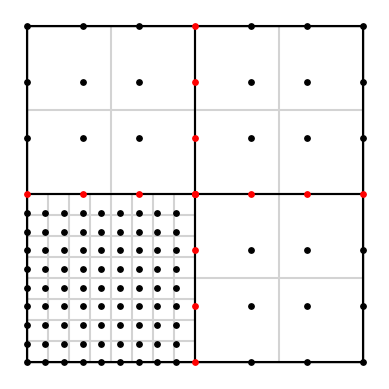

In [47]:
MP.mesh.draw(knots=1,bwidth=1)
#drawLocal(MP)
drawInterior(MP,r=0)
drawSkeleton(MP)
axis('off');
axis('scaled');

In [48]:
patches = [(2*(bspline.make_knots(1,0.0,1.0,2),),geometry.unit_square())]
M = topology.PatchMesh(patches)
M.h_refine({0:None})
M.h_refine({0:-1})
M.h_refine({0:-1})
MP = assemble.Multipatch(M, automatch=True)

setting up constraints took 0.0036230087280273438 seconds.
Basis setup took 0.002957582473754883 seconds


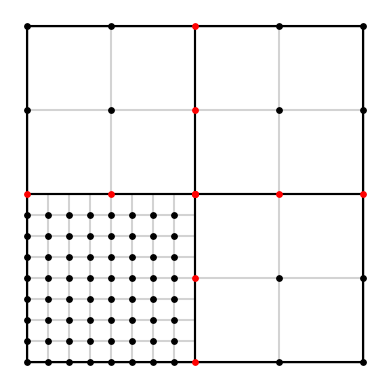

In [49]:
MP.mesh.draw(knots=1)
drawInterior(MP,r=0)
drawSkeleton(MP)

In [50]:
kv1=bspline.KnotVector(np.array([0.0,0.3,0.6,1.0]),0)
kv2=bspline.KnotVector(np.array([0.0,0.2,0.4,0.6,0.8,1.0]),0)

In [51]:
B=bspline.prolongation(kv1,kv2)

In [52]:
B.A.T

array([[1.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 1.000, 1.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 1.000, 1.000]])

In [53]:
kvs=(kv1,kv2)

In [54]:
bspline.numspans(kvs)

15

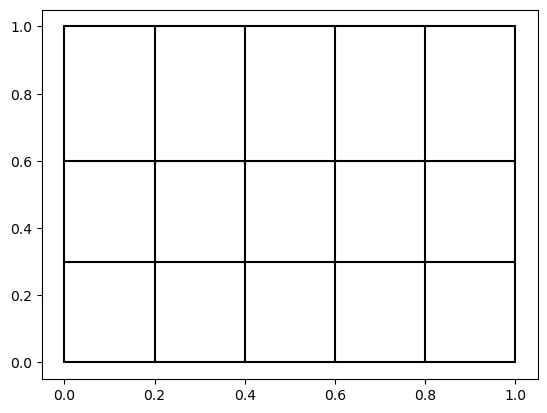

In [55]:
vis.plot_geo(geometry.unit_square(), gridx=kvs[1].mesh, gridy=kvs[0].mesh)

In [56]:
assemble.boundary_dofs(kvs, bdspec=[(0,1)], ravel=1)

array([10, 11, 12, 13, 14])

In [57]:
a={0:1}
b={0:2,3:4}

In [58]:
set(b) - set(a)

{3}

In [59]:
type('a')

str

In [60]:
A = scipy.sparse.coo_matrix(np.array([[1,2],[3,4]])).tocsc()
B = scipy.sparse.csc_matrix(np.array([[1,2],[3,4]]))

In [61]:
A@B

<2x2 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Column format>

In [62]:
A

<2x2 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Column format>

In [63]:
B

<2x2 sparse matrix of type '<class 'numpy.int64'>'
	with 4 stored elements in Compressed Sparse Column format>

In [64]:
S = scipy.sparse.csc_matrix(np.array([[0,1,0],[0,0,0],[0,0,1]]))

In [65]:
S.A

array([[0, 1, 0],
       [0, 0, 0],
       [0, 0, 1]])

In [66]:
(S@S)

<3x3 sparse matrix of type '<class 'numpy.int64'>'
	with 1 stored elements in Compressed Sparse Column format>

In [67]:
S.indptr=np.unique(S.indptr)

In [68]:
S.indices

array([0, 2], dtype=int32)

In [69]:
S.indptr

array([0, 1, 2], dtype=int32)

In [70]:
S._shape=(3,2)

In [71]:
S.indptr=S.indptr[1:]

In [72]:
S.indptr

array([1, 2], dtype=int32)

In [73]:
S.A

array([[0, 0],
       [0, 0],
       [1, 0]])

In [74]:
S.indices

array([0, 2], dtype=int32)

In [75]:
np.array([])

array([], dtype=float64)

In [76]:
algebra_cy.pyx_CauchyMatrix(10)

array([[0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.001],
       [0.000, 0.000, 0.000, 0.000, 0.000, 0.001, 0.002, 0.005, 0.006, 0.007],
       [0.000, 0.000, 0.000, 0.000, 0.001, 0.003, 0.010, 0.024, 0.028, 0.033],
       [0.000, 0.000, 0.000, 0.000, 0.002, 0.010, 0.036, 0.083, 0.100, 0.125],
       [0.000, 0.000, 0.000, 0.001, 0.005, 0.024, 0.083, 0.200, 0.250, 0.333],
       [0.000, 0.000, 0.000, 0.001, 0.006, 0.028, 0.100, 0.250, 0.333, 0.500],
       [0.000, 0.000, 0.000, 0.001, 0.007, 0.033, 0.125, 0.333, 0.500, 1.000]])

In [77]:
n=100000000
data=np.random.rand(n)
ii=np.random.randint(0,n,n)
jj=np.random.randint(0,n,n)

In [78]:
A = scipy.sparse.coo_matrix((data,(ii,jj)),(n,n)).tocsr()
B = A.tocsc()

In [ ]:
%timeit A@A
%timeit A@B
%timeit B@A
%timeit B@B

21.2 s ± 63.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
The slowest run took 118.02 times longer than the fastest. This could mean that an intermediate result is being cached.
8min 16s ± 19min 5s per loop (mean ± std. dev. of 7 runs, 1 loop each)
